In [30]:
import numpy as np 
import torch
import pandas as pd
import package.dataset as dataset
import package.models as models
import package.training as training
from sklearn.model_selection import train_test_split
import importlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer

In [1]:
importlib.reload(dataset)
importlib.reload(models)
importlib.reload(training)

NameError: name 'importlib' is not defined

## Loading dataset

In [3]:
def preprocessing(dataset,columns_to_drop = None):
    # Drop rows with missing values
    dataset = dataset.dropna()

    # Drop columns that are not needed
    if columns_to_drop is not None:
        dataset = dataset.drop(columns=columns_to_drop)

    # Get the list of columns with string data type
    string_columns = dataset.select_dtypes(include=['object']).columns.tolist()
    
    # Convert string columns to dummy variables
    dummy_variables = pd.get_dummies(dataset, columns=string_columns, dtype=float, drop_first=True)

    # Turn all columns to float
    dummy_variables = dummy_variables.astype(float)
    
    return dummy_variables

In [4]:
db = pd.read_csv('datasets/forest_type.csv')
columns_to_drop = ['Id']
db = preprocessing(db,columns_to_drop)

In [5]:
db.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0


In [32]:
X_train, X_test, y_train, y_test = train_test_split(db.drop(columns=['Cover_Type']), db['Cover_Type'], test_size=0.2, random_state=42)

# Normalize the data
normalizer = Normalizer()
X_train = normalizer.fit_transform(X_train.values)
X_test = normalizer.transform(X_test.values)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values-1, dtype=torch.long)
y_test = torch.tensor(y_test.values-1, dtype=torch.long)

In [33]:
trainset = dataset.Dataset(X_train, y_train)
testset = dataset.Dataset(X_test, y_test)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True)

## Training

In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#criterion = torch.nn.MSELoss()
criterion = torch.nn.CrossEntropyLoss()
model = models.Model_MLP_Classification(54, [100,50,20,10,10,10,10], 7, non_linearity='relu', initial_weights='xavier')
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True)
training.train_model(model, trainloader, testloader, device, criterion, 200, optimizer, scheduler, type = 'classification')

/home/aurelien.stumpf/Code/deep_env/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 0
lr:  0.01
578.1255341172218
Training Loss
Accuracy: 50.23974867724868
Loss: 0.03546904547327252
Test Loss
Accuracy: 50.925925925925924
Loss: 0.03547629079333058
-------------------------
Epoch 10
lr:  0.01
354.3728944659233
Training Loss
Accuracy: 62.136243386243386
Loss: 0.026514125588749136
Test Loss
Accuracy: 62.863756613756614
Loss: 0.026591452222967906
-------------------------
Epoch 20
lr:  0.01
333.0257902443409
Training Loss
Accuracy: 62.02876984126984
Loss: 0.025720419061601794
Test Loss
Accuracy: 61.93783068783069
Loss: 0.02602826425480464
-------------------------
Epoch 30
lr:  0.01
318.3159547448158
Training Loss
Accuracy: 58.804563492063494
Loss: 0.027778657833262096
Test Loss
Accuracy: 58.7962962962963
Loss: 0.027618907135788094
-------------------------
Epoch 40
lr:  0.01
305.5373983979225
Training Loss
Accuracy: 64.68253968253968
Loss: 0.023964987924844815
Test Loss
Accuracy: 64.68253968253968
Loss: 0.024187661116085356
-------------------------
Epoch 50
lr:  0.

In [39]:
training.train_model(model, trainloader, testloader, device, criterion, 100, optimizer, scheduler, type = 'classification')

Epoch 0
lr:  0.0001
Training Loss
Accuracy: 57.44047619047619
Loss: 0.029744349464419343
Test Loss
Accuracy: 59.060846560846564
Loss: 0.029667662978960722
-------------------------
Epoch 10
lr:  0.0001
Training Loss
Accuracy: 57.76289682539682
Loss: 0.029758468487117655
Test Loss
Accuracy: 58.99470899470899
Loss: 0.02981478557305992
-------------------------
Epoch 20
lr:  0.0001
Training Loss
Accuracy: 58.13492063492063
Loss: 0.02941702811352948
Test Loss
Accuracy: 59.88756613756614
Loss: 0.029062779275355517
-------------------------
Epoch 30
lr:  0.0001
Training Loss
Accuracy: 55.357142857142854
Loss: 0.031015853515811383
Test Loss
Accuracy: 57.01058201058201
Loss: 0.0304153316787311
-------------------------
Epoch 40
lr:  0.0001
Training Loss
Accuracy: 59.383267195767196
Loss: 0.028447768143402836
Test Loss
Accuracy: 61.37566137566137
Loss: 0.028149811698803828
-------------------------
Epoch 50
lr:  0.0001
Training Loss
Accuracy: 59.83796296296296
Loss: 0.028088787802194478
Test Lo

## Visualization 

l1.weight


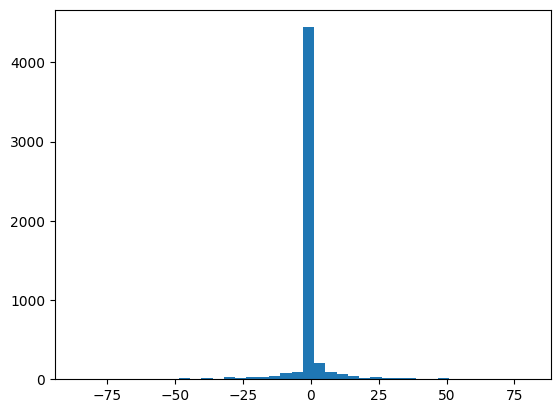

l1.bias


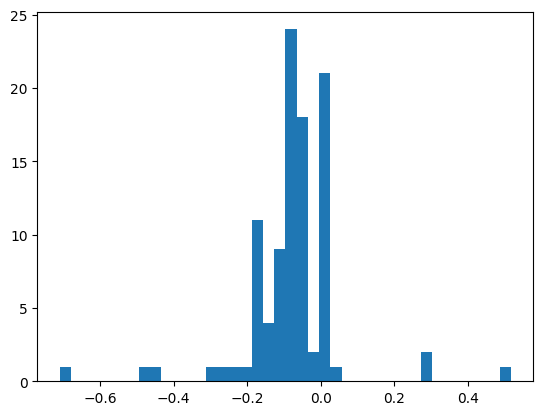

l2.weight


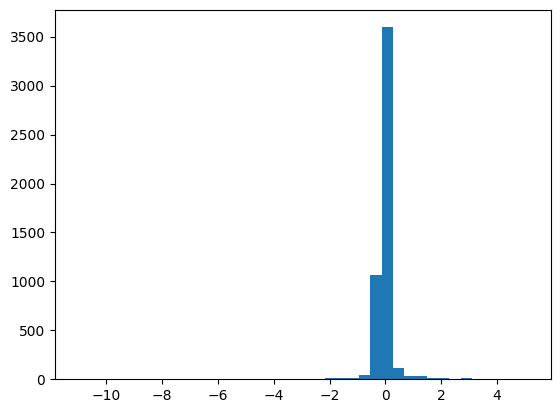

l2.bias


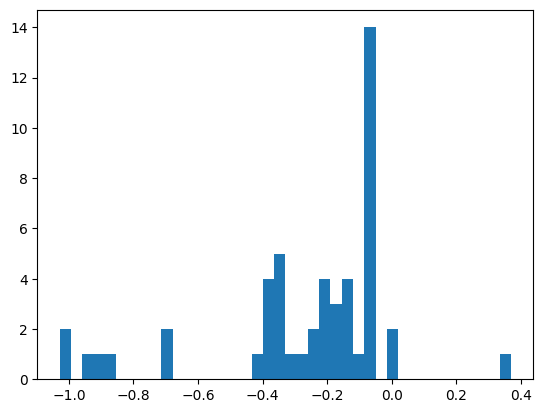

l3.weight


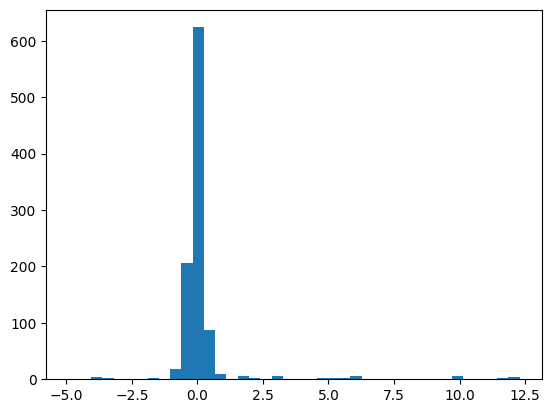

l3.bias


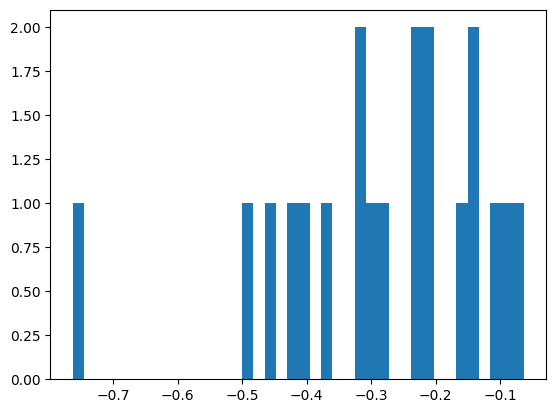

l4.weight


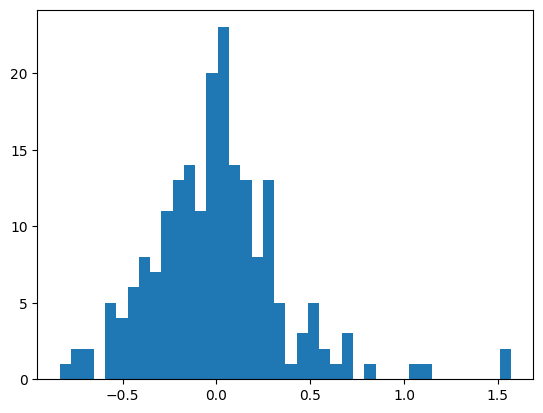

l4.bias


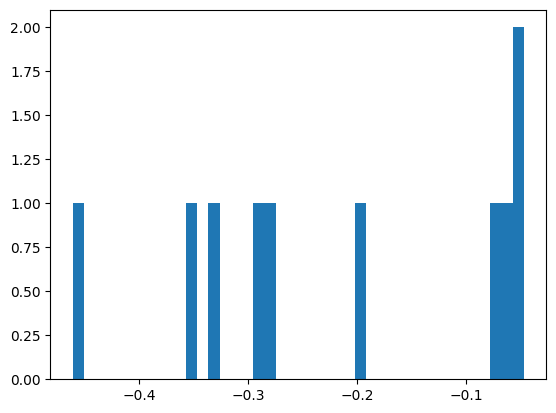

l5.weight


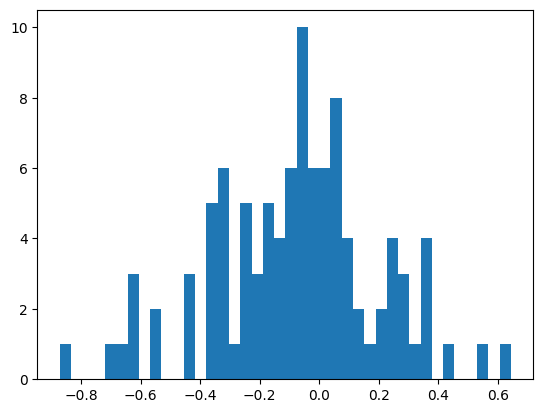

l5.bias


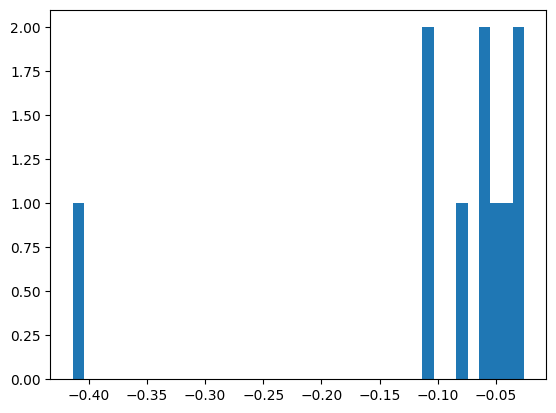

l6.weight


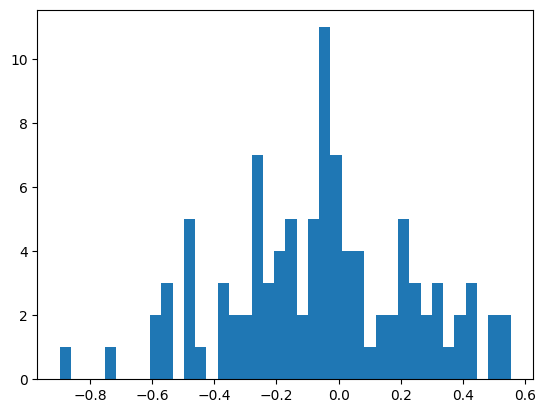

l6.bias


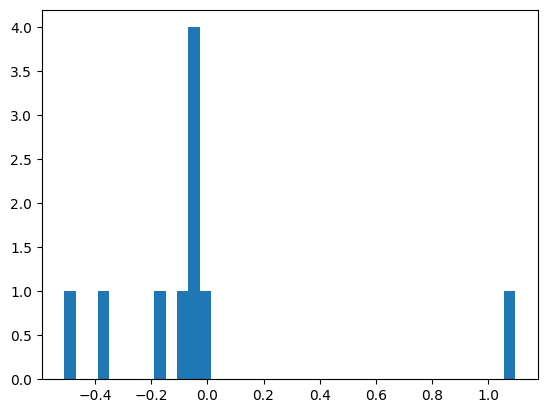

l7.weight


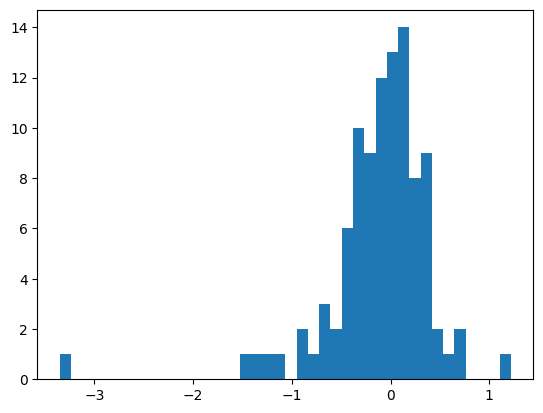

l7.bias


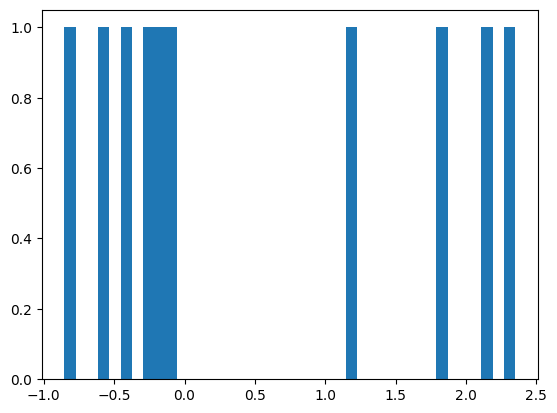

l8.weight


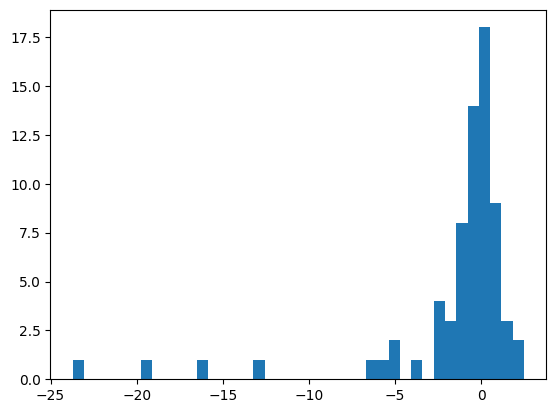

l8.bias


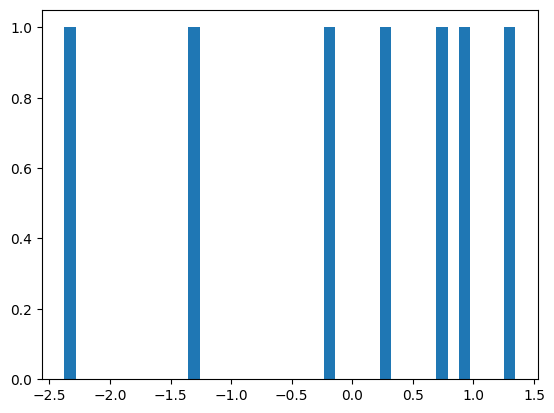

In [56]:
for layer in model.named_parameters():
    weights = layer[1].data.cpu().numpy()
    print(f'{layer[0]}')
    plt.hist(weights.flatten(), bins=40)
    plt.show()

layer0
degree_out


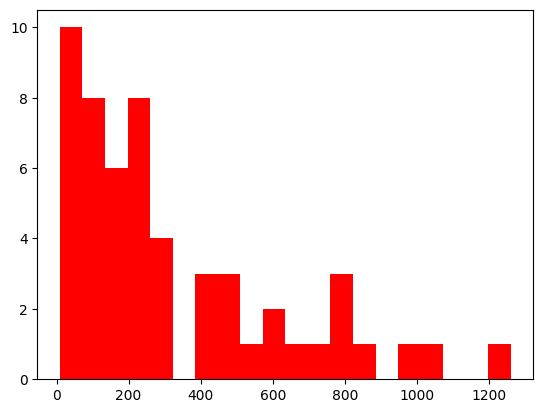

layer1
degree_in


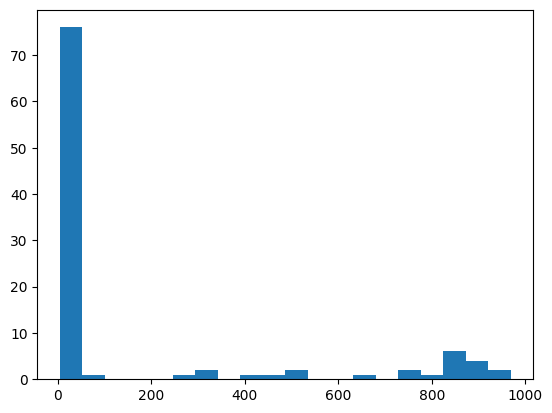

degree_out


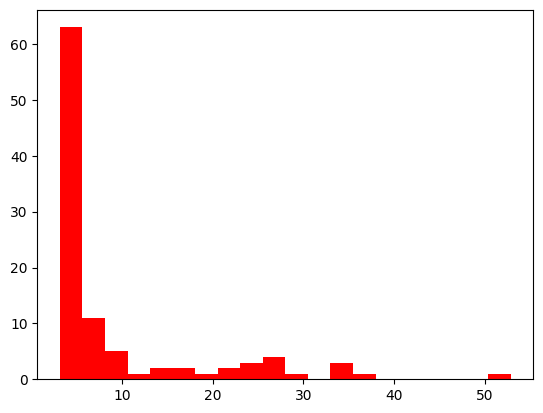

layer2
degree_in


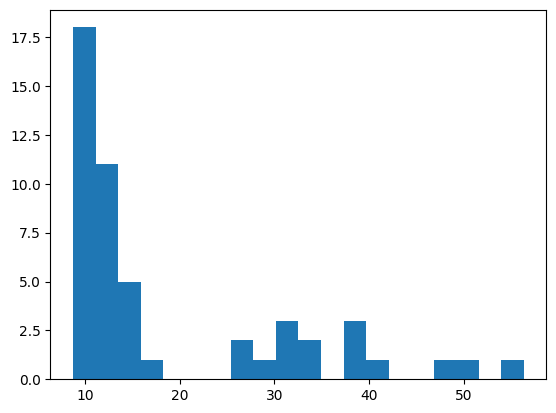

degree_out


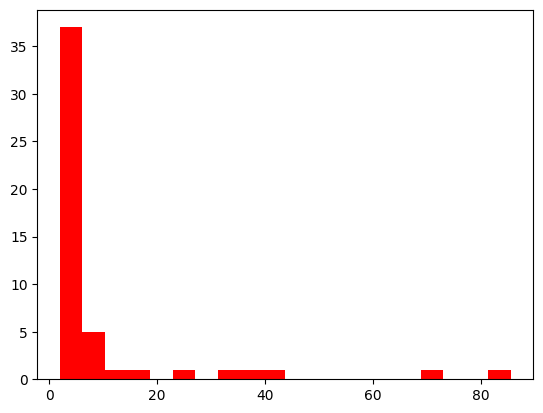

layer3
degree_in


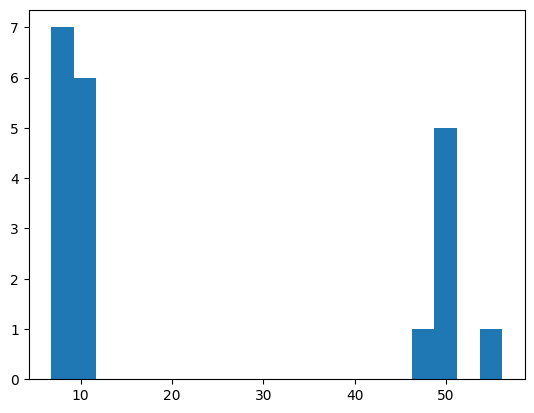

degree_out


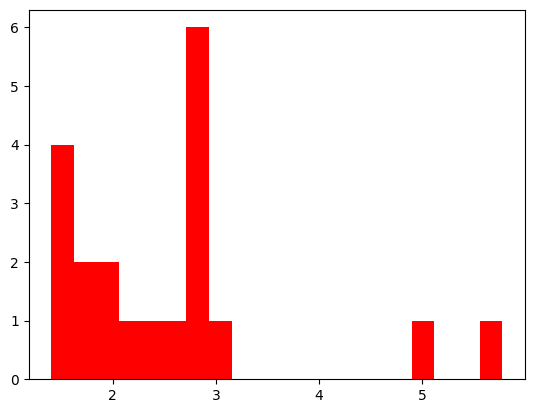

layer4
degree_in


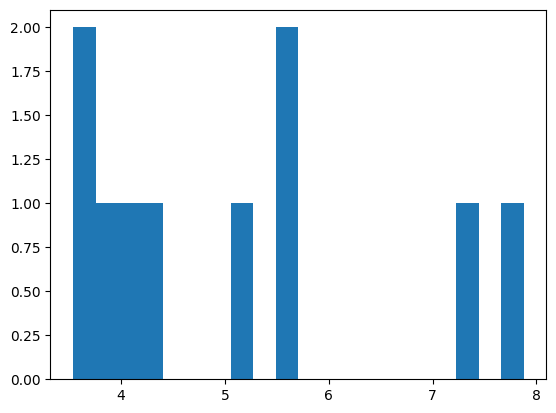

degree_out


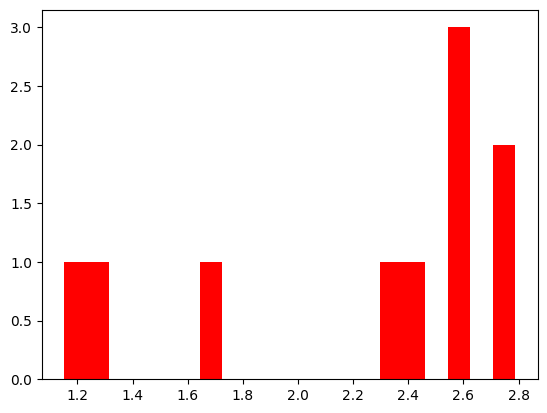

layer5
degree_in


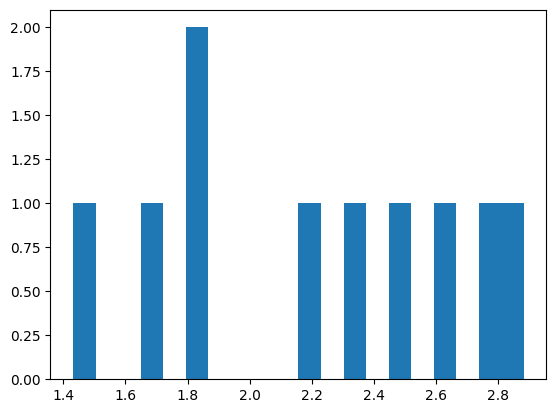

degree_out


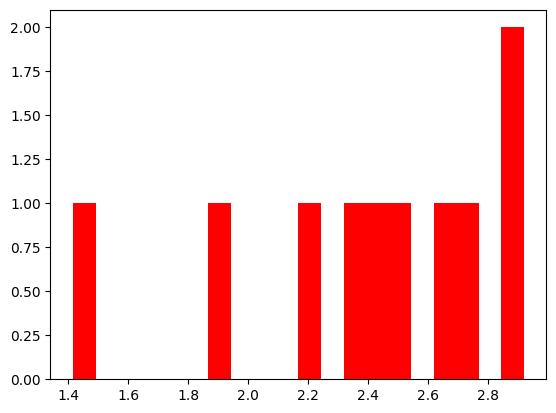

layer6
degree_in


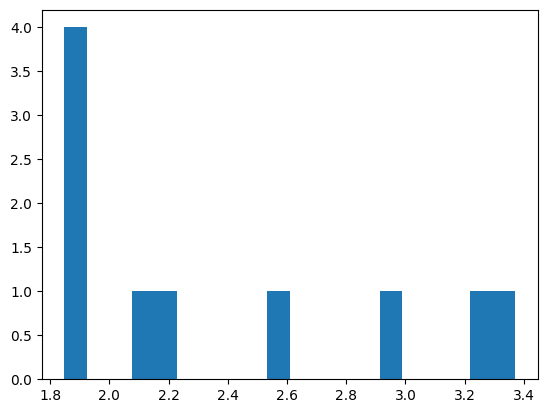

degree_out


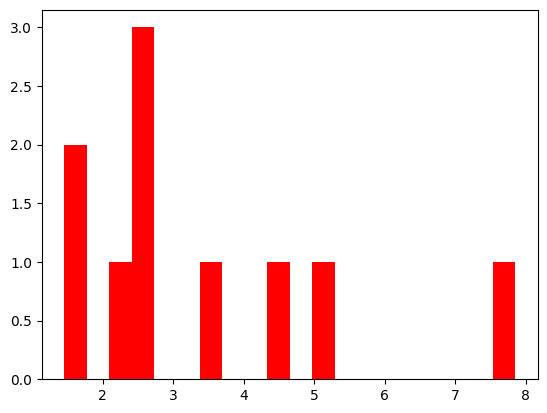

layer7
degree_in


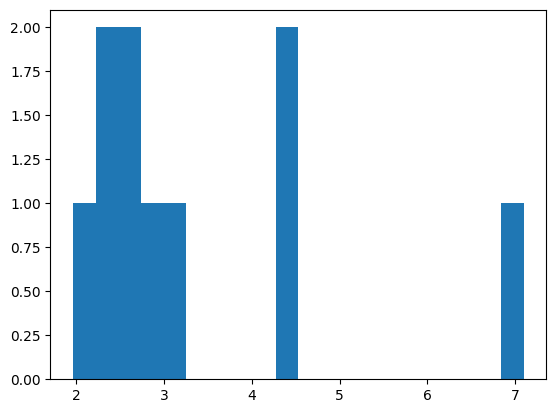

degree_out


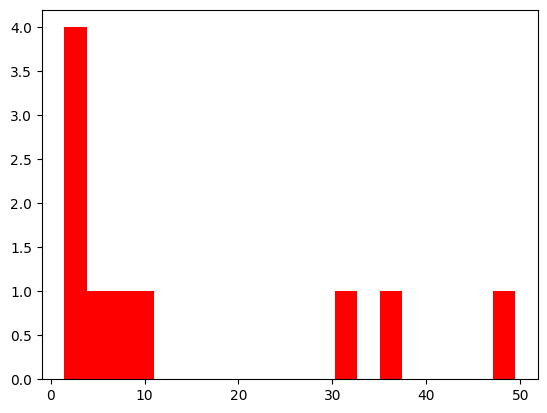

layer8
degree_in


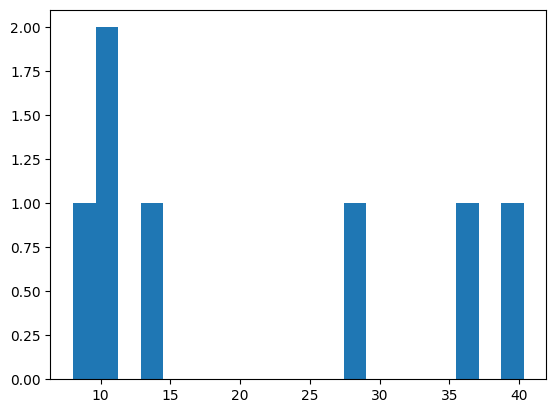

In [57]:
i=0
for layer in model.named_parameters():
    weights = layer[1].data.cpu().numpy()
    if len(weights.shape) > 1:
        if i == 0:
            print("layer{}".format(i))
        degree_out = np.sum(np.abs(weights), axis=0)
        print("degree_out")
        plt.hist(degree_out, bins=20, color='red')
        plt.show()
        i += 1
        if i > 0:
            print("layer{}".format(i))
        print("degree_in")
        degree_in = np.sum(np.abs(weights), axis=1)
        plt.hist(degree_in, bins=20)
        plt.show()

layer0
[-0.04138026 -0.0198009  -0.04900631 ... -0.55975544 -1.8533837
 -0.32457522]
degree_out_neg


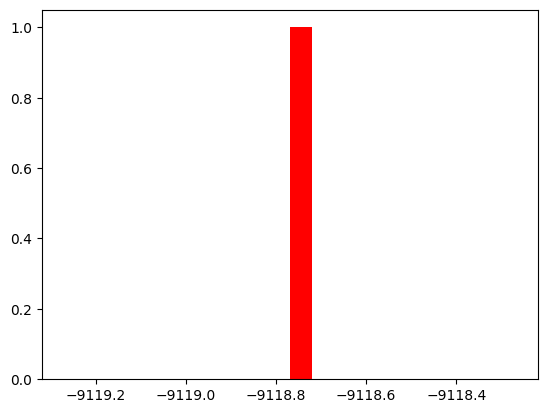

degree_out_pos


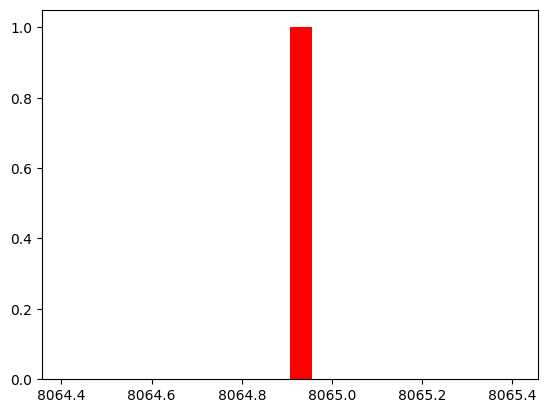

layer1
degree_in_neg


AxisError: axis 1 is out of bounds for array of dimension 1

In [65]:
i=0
for layer in model.named_parameters():
    weights = layer[1].data.cpu().numpy()
    if len(weights.shape) > 1:
        if i == 0:
            print("layer{}".format(i))   
        degree_out_neg = np.sum(weights[weights < 0], axis=0)
        print("degree_out_neg")
        plt.hist(degree_out_neg, bins=20, color='red')
        plt.show()
        degree_out_pos = np.sum(weights[weights > 0], axis=0)
        print("degree_out_pos")
        plt.hist(degree_out_pos, bins=20, color='red')
        plt.show()
        i += 1
        if i > 0:
            print("layer{}".format(i))
        print("degree_in_neg")
        degree_in_neg = np.sum(weights[weights < 0], axis=1)
        plt.hist(degree_in_neg, bins=20)
        plt.show()
        degree_in_pos = np.sum(weights[weights > 0], axis=1)
        print("degree_in_pos")
        plt.hist(degree_in_pos, bins=20)
        plt.show()

layer0
degree_out


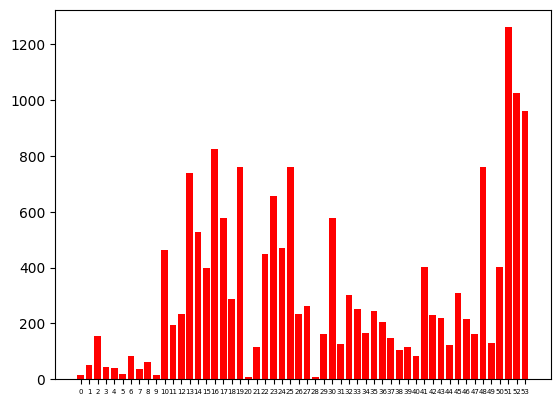

layer1
degree_in


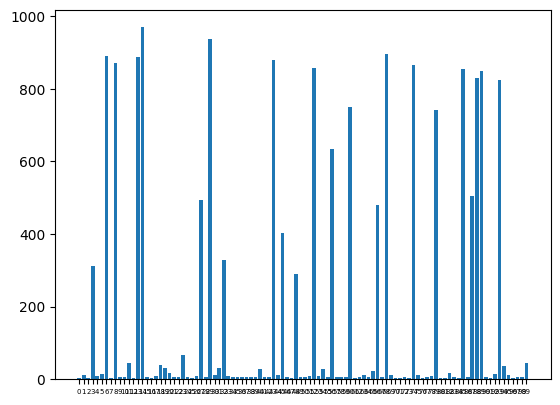

degree_out


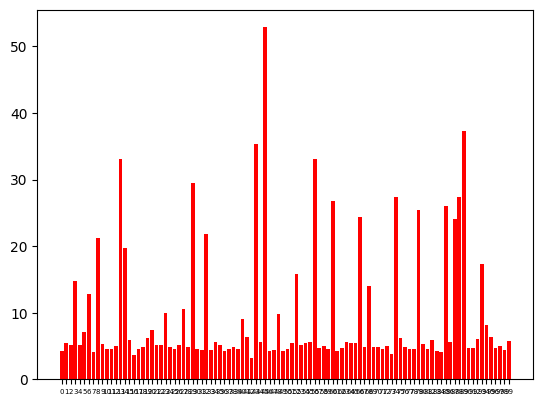

layer2
degree_in


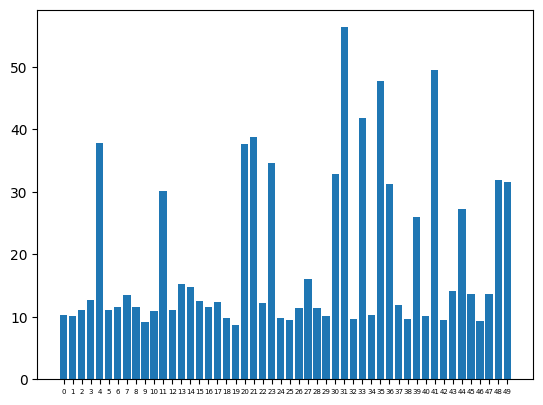

degree_out


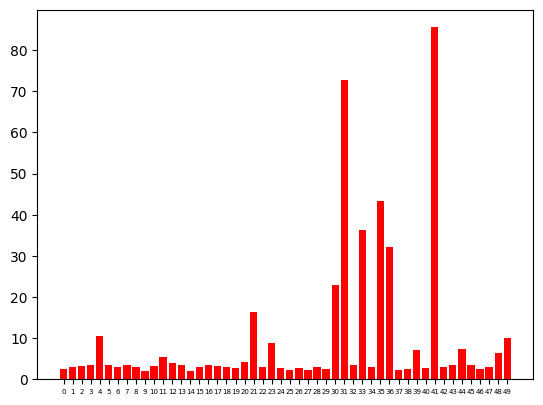

layer3
degree_in


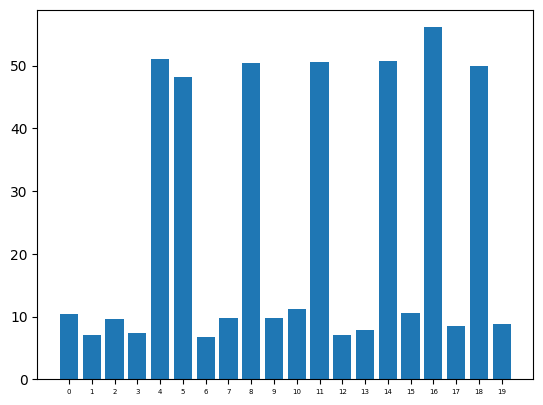

degree_out


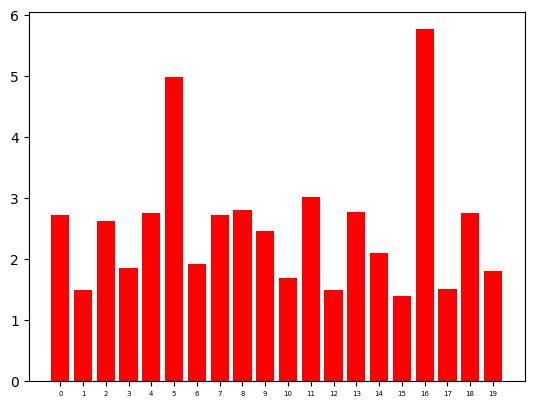

layer4
degree_in


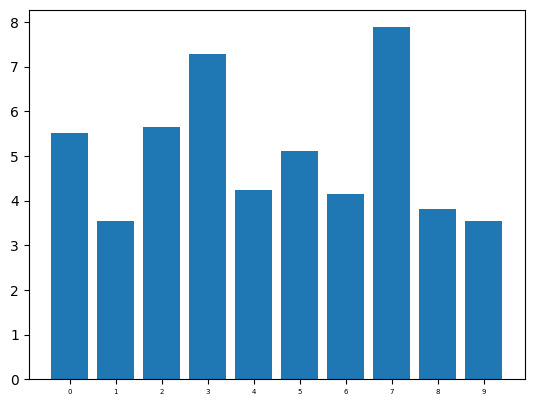

degree_out


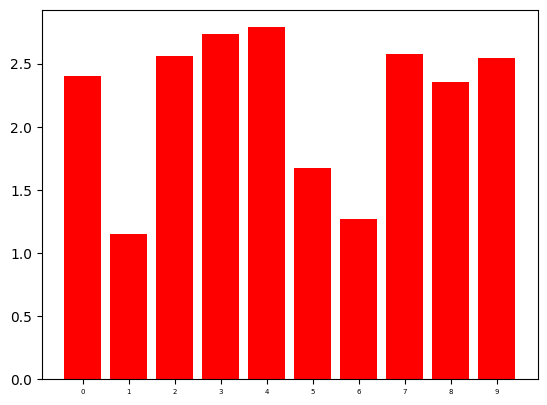

layer5
degree_in


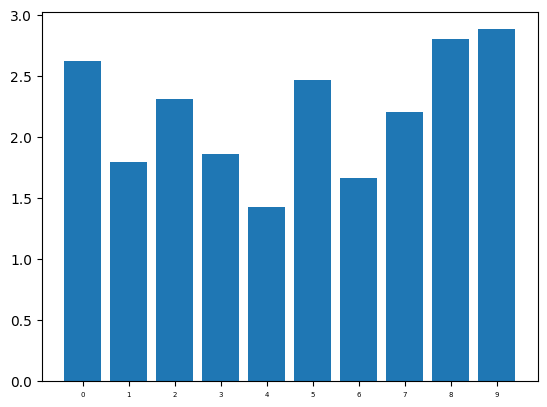

degree_out


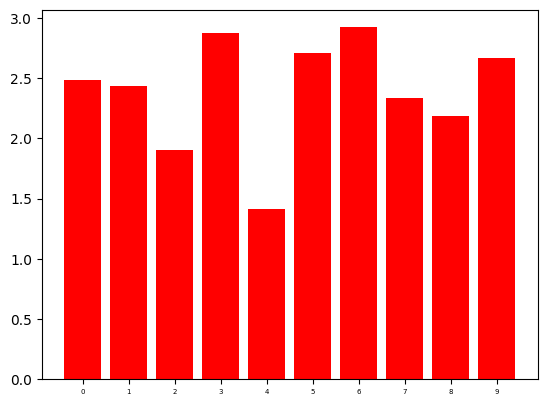

layer6
degree_in


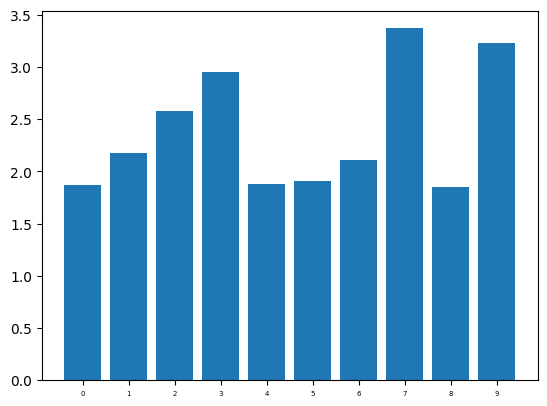

degree_out


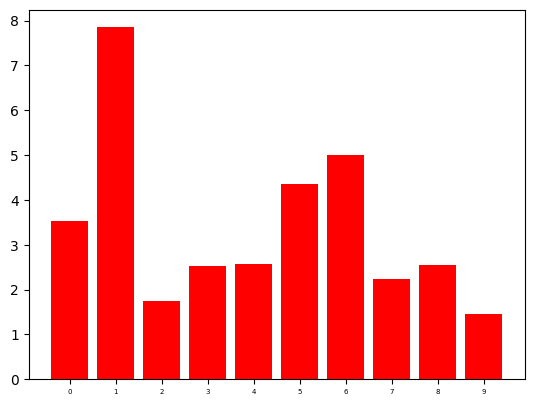

layer7
degree_in


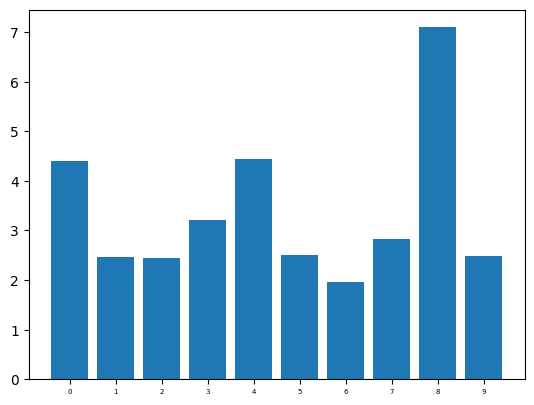

degree_out


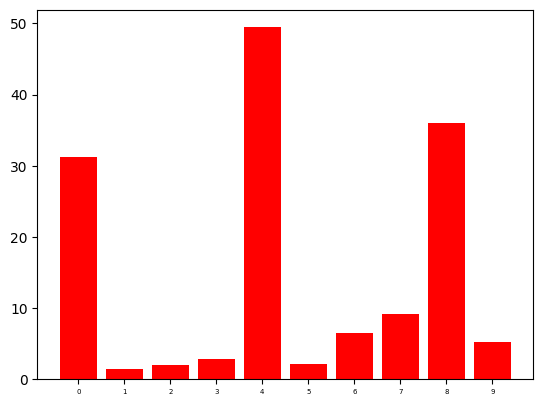

layer8
degree_in


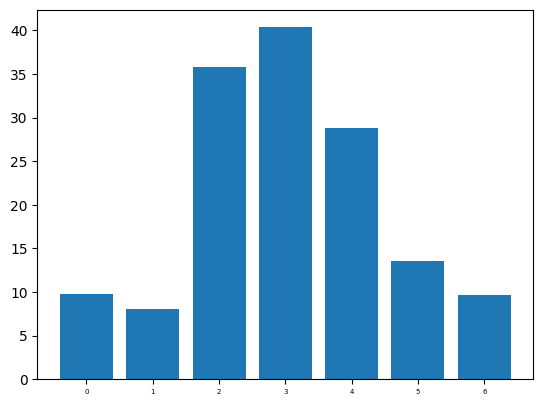

In [58]:
i=0
for layer in model.named_parameters():
    weights = layer[1].data.cpu().numpy()
    if len(weights.shape) > 1:
        if i == 0:
            print("layer{}".format(i))
        degree_out = np.sum(np.abs(weights), axis=0)
        print("degree_out")
        plt.bar(np.arange(weights.shape[1]),degree_out, color='red')
        plt.xticks(np.arange(weights.shape[1]), rotation=0, fontsize=5)
        plt.show()
        i += 1
        if i > 0:
            print("layer{}".format(i))
        print("degree_in")
        degree_in = np.sum(np.abs(weights), axis=1)
        plt.bar(np.arange(weights.shape[0]),degree_in)
        plt.xticks(np.arange(weights.shape[0]), rotation=0, fontsize=5)
        plt.show()